<a id="top"></a>
# Tutorial Title

***

## Learning Goals

By the end of this tutorial, you will:

- Use astroquery to access archived HST images
- Understand the need for image alignment
- Learn how to download calibration files with CRDS
- Use DrizzlePac and the calibration files to align your collected images
- Combine images to create your very own previews of targets for future proposals, including for JWST!


## Introduction

Whether you want to re-explore existing data to learn something or discover something new, or you want to make the case for a new observation with Hubble or another telescope, you will want to download and combine all the existing data. These are all meticulously stored in the Mikulski Archive for Space Telescopes ([MAST](https://science.nasa.gov/astrophysics/astrophysics-data-centers/multimission-archive-at-stsci-mast/)). You can interactively search for and view individual images on the website.

This tutorial allows you to make the most of existing observations by combining, or stacking, them. Several different observations of the same source may have been approved over Hubble's 30 year history, from a variety of PIs (principal investigators) and for a variety of science goals. Three things will almost certainly vary between visits, however:
- the instrument ([ACS](https://www.stsci.edu/hst/instrumentation/acs) or [WFC3](https://www.stsci.edu/hst/instrumentation/wfc3) for imaging) and the [filters](https://hubblesite.org/mission-and-telescope/instruments)
- the pointing direction of the instrument
- because the images were taken at different times, they will have different pixels affected by cosmic rays, high-energy particles that interact with the instrument to produce a shower of pixels unrelated to the sources of interest.

[`Drizzlepac`](https://www.stsci.edu/scientific-community/software/drizzlepac.html) is a Python module that performs all the necessary image cleaning and combining. This tutorial will guide you through it to create a stacked image of the Orion Nebula, a beautiful extended source that is rich with science in multiple wavelengths. 

Before starting, [set up AstroConda](https://astroconda.readthedocs.io/en/latest/installation.html). Then, follow [this tutorial](https://github.com/spacetelescope/notebooks/blob/master/notebooks/DrizzlePac/Initialization/Initialization.ipynb) to set up DrizzlePac on your computer.

## Imports

- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *astropy.table Table* for creating tidy tables of the data
- *matplotlib.pyplot* for plotting data
- *astroquery* for pulling data from the Mikulski Archive at Space Telescope (MAST)
- *stwcs* for tracking the World Coordinate System (WCS) data in the image files
- *subprocess* to parallelize tasks
- *shutil*, *glob*, *os* for accessing and manipulating files in the local system 

The easiest way to make sure you have all the relevant modules is to download the Astroconda environment. Due to a known error, for Drizzlepac to work, you need to specify older versions for a couple packages:

```
conda deactivate
conda update --all
conda create -n astroconda -c http://ssb.stsci.edu/astroconda stsci python=3.7 photutils=1.0.2 markupsafe=2.0.1 astroquery drizzlepac stwcs 
conda activate astroconda
```

In [1]:
%matplotlib inline
import numpy as np
from astropy.io import fits
from astropy.table import vstack, Table
import matplotlib.pyplot as plt
from astroquery.mast import Mast
from astroquery.mast import Observations
import shutil, stwcs, subprocess, glob, os 

from stwcs.updatewcs import updatewcs
from drizzlepac import tweakreg, astrodrizzle, photeq
from stsci.skypac import skymatch



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


## Downloading Existing Images with astroquery.Observations

Let's start by retrieving images of the Orion Nebula, our object of interest, from the HST Archive. Astroquery.Observations allows you to query targets by name, and it is helpful to additionally specify a search radius. 

More famous objects have been observed by Hubble many times, so the download may be prohibitively large. You may want to select only images in a certain band, or apply filters on any of the [fields listed here.]( https://mast.stsci.edu/api/v0/_c_a_o_mfields.html). Here, we require `calib_level = 3` to ensure that the image is science quality. 

In [2]:
obs_table = Observations.query_criteria(target_name=["Orion","OrionNebula"],intentType='science',
                                        dataproduct_type='image', calib_level=3)
obs_table

dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID
str5,int64,str3,str9,str11,float64,float64,float64,float64,float64,str8,str14,float64,float64,str11,str27,float64,str7,str14,str5,str7,str3,int64,str6,str107,str34,str35,str6,bool,float64,str7,str8,str9
image,3,HST,j8up02usq,ORIONNEBULA,83.81875,-5.38975,53025.179451655094,53025.1811996875,150.0,Optical,CLEAR1L;FR656N,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.78548604,ACS/WFC,"Jogee, Shardha",10057,CAL/ACS,HST,--,CALACS,POLYGON 83.817931 -5.410508 83.798123 -5.388606 83.819603 -5.36935 83.839412 -5.391251 83.817931 -5.410508,mast:HST/product/j8up02usq_drz.jpg,mast:HST/product/j8up02usq_drz.fits,PUBLIC,False,nan,science,24016393,121741157
image,3,HST,j8up02utq,ORIONNEBULA,83.81875,-5.38975,53025.18352569445,53025.18527376158,150.0,Optical,CLEAR1L;FR656N,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.78619211,ACS/WFC,"Jogee, Shardha",10057,CAL/ACS,HST,--,CALACS,POLYGON 83.817931 -5.410508 83.798123 -5.388606 83.819603 -5.36935 83.839412 -5.391251 83.817931 -5.410508,mast:HST/product/j8up02utq_drz.jpg,mast:HST/product/j8up02utq_drz.fits,PUBLIC,False,nan,science,24016394,121741219
image,3,HST,j8up02uuq,ORIONNEBULA,83.81875,-5.38975,53025.18759980324,53025.18934783565,150.0,Optical,CLEAR1L;FR656N,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.78692124,ACS/WFC,"Jogee, Shardha",10057,CAL/ACS,HST,--,CALACS,POLYGON 83.817931 -5.410508 83.798123 -5.388606 83.819603 -5.36935 83.839412 -5.391251 83.817931 -5.410508,mast:HST/product/j8up02uuq_drz.jpg,mast:HST/product/j8up02uuq_drz.fits,PUBLIC,False,nan,science,24016395,121741204
image,3,HST,j8up02uvq,ORIONNEBULA,83.81875,-5.38975,53025.19178943287,53025.193537465275,150.0,Optical,CLEAR1L;FR388N,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.78775462,ACS/WFC,"Jogee, Shardha",10057,CAL/ACS,HST,--,CALACS,POLYGON 83.817931 -5.410508 83.798123 -5.388606 83.819603 -5.369349 83.839412 -5.391251 83.817931 -5.410508,mast:HST/product/j8up02uvq_drz.jpg,mast:HST/product/j8up02uvq_drz.fits,PUBLIC,False,nan,science,24016396,121741214
image,3,HST,j8up02uwq,ORIONNEBULA,83.81875,-5.38975,53025.19584054398,53025.20048190972,400.0,Optical,CLEAR1L;FR388N,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.60020823,ACS/WFC,"Jogee, Shardha",10057,CAL/ACS,HST,--,CALACS,POLYGON 83.817931 -5.410508 83.798123 -5.388605 83.819603 -5.369349 83.839412 -5.391251 83.817931 -5.410508,mast:HST/product/j8up02uwq_drz.jpg,mast:HST/product/j8up02uwq_drz.fits,PUBLIC,False,nan,science,24016397,121741185
image,3,HST,j8up02uyq,ORIONNEBULA,83.81875,-5.38975,53025.202993136576,53025.20474116898,150.0,Optical,CLEAR1L;FR505N,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.60090273,ACS/WFC,"Jogee, Shardha",10057,CAL/ACS,HST,--,CALACS,POLYGON 83.817931 -5.410507 83.798123 -5.388605 83.819603 -5.369349 83.839412 -5.391251 83.817931 -5.410507,mast:HST/product/j8up02uyq_drz.jpg,mast:HST/product/j8up02uyq_drz.fits,PUBLIC,False,nan,science,24016398,121741174
image,3,HST,j8up02v0q,ORIONNEBULA,83.81875,-5.38975,53025.20706721065,53025.20881524306,150.0,Optical,CLEAR1L;FR505N,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.78953694,ACS/WFC,"Jogee, Shardha",10057,CAL/ACS,HST,--,CALACS,POLYGON 83.817931 -5.410507 83.798123 -5.388605 83.819603 -5.369349 83.839412 -5.391251 83.817931 -5.410507,mast:HST/product/j8up02v0q_drz.jpg,mast:HST/product/j8up02v0q_drz.fits,PUBLIC,False,nan,science,24016399,121741211
image,3,HST,j8up02v5q,ORIONNEBULA,83.81875,-5.38975,53025.24283128472,53025.24457931713,150.0,Optical,CLEAR1L;FR459M,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.79164349,ACS/WFC,"Jogee, Shardha",10057,CAL/AC

In [3]:
optical = obs_table[obs_table['wavelength_region']=='Optical']
infrared = obs_table[(obs_table['wavelength_region'] == 'Infrared')] 
optical

dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID
str5,int64,str3,str9,str11,float64,float64,float64,float64,float64,str8,str14,float64,float64,str11,str27,float64,str7,str14,str5,str7,str3,int64,str6,str107,str34,str35,str6,bool,float64,str7,str8,str9
image,3,HST,j8up02usq,ORIONNEBULA,83.81875,-5.38975,53025.179451655094,53025.1811996875,150.0,Optical,CLEAR1L;FR656N,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.78548604,ACS/WFC,"Jogee, Shardha",10057,CAL/ACS,HST,--,CALACS,POLYGON 83.817931 -5.410508 83.798123 -5.388606 83.819603 -5.36935 83.839412 -5.391251 83.817931 -5.410508,mast:HST/product/j8up02usq_drz.jpg,mast:HST/product/j8up02usq_drz.fits,PUBLIC,False,nan,science,24016393,121741157
image,3,HST,j8up02utq,ORIONNEBULA,83.81875,-5.38975,53025.18352569445,53025.18527376158,150.0,Optical,CLEAR1L;FR656N,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.78619211,ACS/WFC,"Jogee, Shardha",10057,CAL/ACS,HST,--,CALACS,POLYGON 83.817931 -5.410508 83.798123 -5.388606 83.819603 -5.36935 83.839412 -5.391251 83.817931 -5.410508,mast:HST/product/j8up02utq_drz.jpg,mast:HST/product/j8up02utq_drz.fits,PUBLIC,False,nan,science,24016394,121741219
image,3,HST,j8up02uuq,ORIONNEBULA,83.81875,-5.38975,53025.18759980324,53025.18934783565,150.0,Optical,CLEAR1L;FR656N,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.78692124,ACS/WFC,"Jogee, Shardha",10057,CAL/ACS,HST,--,CALACS,POLYGON 83.817931 -5.410508 83.798123 -5.388606 83.819603 -5.36935 83.839412 -5.391251 83.817931 -5.410508,mast:HST/product/j8up02uuq_drz.jpg,mast:HST/product/j8up02uuq_drz.fits,PUBLIC,False,nan,science,24016395,121741204
image,3,HST,j8up02uvq,ORIONNEBULA,83.81875,-5.38975,53025.19178943287,53025.193537465275,150.0,Optical,CLEAR1L;FR388N,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.78775462,ACS/WFC,"Jogee, Shardha",10057,CAL/ACS,HST,--,CALACS,POLYGON 83.817931 -5.410508 83.798123 -5.388606 83.819603 -5.369349 83.839412 -5.391251 83.817931 -5.410508,mast:HST/product/j8up02uvq_drz.jpg,mast:HST/product/j8up02uvq_drz.fits,PUBLIC,False,nan,science,24016396,121741214
image,3,HST,j8up02uwq,ORIONNEBULA,83.81875,-5.38975,53025.19584054398,53025.20048190972,400.0,Optical,CLEAR1L;FR388N,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.60020823,ACS/WFC,"Jogee, Shardha",10057,CAL/ACS,HST,--,CALACS,POLYGON 83.817931 -5.410508 83.798123 -5.388605 83.819603 -5.369349 83.839412 -5.391251 83.817931 -5.410508,mast:HST/product/j8up02uwq_drz.jpg,mast:HST/product/j8up02uwq_drz.fits,PUBLIC,False,nan,science,24016397,121741185
image,3,HST,j8up02uyq,ORIONNEBULA,83.81875,-5.38975,53025.202993136576,53025.20474116898,150.0,Optical,CLEAR1L;FR505N,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.60090273,ACS/WFC,"Jogee, Shardha",10057,CAL/ACS,HST,--,CALACS,POLYGON 83.817931 -5.410507 83.798123 -5.388605 83.819603 -5.369349 83.839412 -5.391251 83.817931 -5.410507,mast:HST/product/j8up02uyq_drz.jpg,mast:HST/product/j8up02uyq_drz.fits,PUBLIC,False,nan,science,24016398,121741174
image,3,HST,j8up02v0q,ORIONNEBULA,83.81875,-5.38975,53025.20706721065,53025.20881524306,150.0,Optical,CLEAR1L;FR505N,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.78953694,ACS/WFC,"Jogee, Shardha",10057,CAL/ACS,HST,--,CALACS,POLYGON 83.817931 -5.410507 83.798123 -5.388605 83.819603 -5.369349 83.839412 -5.391251 83.817931 -5.410507,mast:HST/product/j8up02v0q_drz.jpg,mast:HST/product/j8up02v0q_drz.fits,PUBLIC,False,nan,science,24016399,121741211
image,3,HST,j8up02v5q,ORIONNEBULA,83.81875,-5.38975,53025.24283128472,53025.24457931713,150.0,Optical,CLEAR1L;FR459M,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.79164349,ACS/WFC,"Jogee, Shardha",10057,CAL/AC

In [16]:
infrared

dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID
str5,int64,str3,str9,str11,float64,float64,float64,float64,float64,str8,str14,float64,float64,str11,str27,float64,str7,str14,str5,str7,str3,int64,str6,str107,str34,str35,str6,bool,float64,str7,str8,str9
image,3,HST,j8up02vbq,ORIONNEBULA,83.81875,-5.38975,53025.255122766204,53025.256870798614,150.0,Infrared,CLEAR1L;FR914M,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.79339104,ACS/WFC,"Jogee, Shardha",10057,CAL/ACS,HST,--,CALACS,POLYGON 83.817931 -5.410508 83.798123 -5.388606 83.819603 -5.36935 83.839412 -5.391251 83.817931 -5.410508,mast:HST/product/j8up02vbq_drz.jpg,mast:HST/product/j8up02vbq_drz.fits,PUBLIC,False,nan,science,24016403,121741155
image,3,HST,j8up02vcq,ORIONNEBULA,83.81875,-5.38975,53025.25919684028,53025.26094487269,150.0,Infrared,CLEAR1L;FR914M,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.79408554,ACS/WFC,"Jogee, Shardha",10057,CAL/ACS,HST,--,CALACS,POLYGON 83.817931 -5.410508 83.798123 -5.388606 83.819603 -5.369349 83.839412 -5.391251 83.817931 -5.410508,mast:HST/product/j8up02vcq_drz.jpg,mast:HST/product/j8up02vcq_drz.fits,PUBLIC,False,nan,science,24016404,121741190
image,3,HST,j8up02vdq,ORIONNEBULA,83.81875,-5.38975,53025.26327091435,53025.26501894676,150.0,Infrared,CLEAR1L;FR914M,200.0,1100.0,CALIBRATION,ACS Ramp Filter Calibration,53025.79479152,ACS/WFC,"Jogee, Shardha",10057,CAL/ACS,HST,--,CALACS,POLYGON 83.817931 -5.410508 83.798123 -5.388605 83.819603 -5.369349 83.839412 -5.391251 83.817931 -5.410508,mast:HST/product/j8up02vdq_drz.jpg,mast:HST/product/j8up02vdq_drz.fits,PUBLIC,False,nan,science,24016405,121741168


It looks like Hubble has 13 science quality observations of the Orion Nebula, of which 13 are at optical wavelengths and 3 in the infrared. Let us process these separately.

In [18]:
download_opt = Observations.download_products(optical['obsid'], extension='fits')

INFO: Found cached file ./mastDownload/HST/j8up02usq/j8up02usq_flt_hlet.fits with expected size 34560. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/j8up02usq/j8up02usj_jif.fits with expected size 34560. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/j8up02usq/j8up02usj_jit.fits with expected size 20160. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/j8up02usq/j8up02usq_spt.fits with expected size 57600. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/j8up02usq/j8up02usq_trl.fits with expected size 66240. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/j8up02usq/j8up02usq_raw.fits with expected size 8513280. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/j8up02usq/j8up02usq_drz.fits with expected size 52948800. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/j8up02usq/j8up02usq_flt.fits with expected size 41990400. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/j8up02ut

Local Path,Status,Message,URL
str52,str8,object,object
./mastDownload/HST/j8up02usq/j8up02usq_flt_hlet.fits,COMPLETE,None,None
./mastDownload/HST/j8up02usq/j8up02usj_jif.fits,COMPLETE,None,None
./mastDownload/HST/j8up02usq/j8up02usj_jit.fits,COMPLETE,None,None
./mastDownload/HST/j8up02usq/j8up02usq_spt.fits,COMPLETE,None,None
./mastDownload/HST/j8up02usq/j8up02usq_trl.fits,COMPLETE,None,None
./mastDownload/HST/j8up02usq/j8up02usq_raw.fits,COMPLETE,None,None
./mastDownload/HST/j8up02usq/j8up02usq_drz.fits,COMPLETE,None,None
./mastDownload/HST/j8up02usq/j8up02usq_flt.fits,COMPLETE,None,None
./mastDownload/HST/j8up02utq/j8up02utq_flt_hlet.fits,COMPLETE,None,None


In [21]:
download_opt

Local Path,Status,Message,URL
str52,str8,object,object
./mastDownload/HST/j8up02usq/j8up02usq_flt_hlet.fits,COMPLETE,None,None
./mastDownload/HST/j8up02usq/j8up02usj_jif.fits,COMPLETE,None,None
./mastDownload/HST/j8up02usq/j8up02usj_jit.fits,COMPLETE,None,None
./mastDownload/HST/j8up02usq/j8up02usq_spt.fits,COMPLETE,None,None
./mastDownload/HST/j8up02usq/j8up02usq_trl.fits,COMPLETE,None,None
./mastDownload/HST/j8up02usq/j8up02usq_raw.fits,COMPLETE,None,None
./mastDownload/HST/j8up02usq/j8up02usq_drz.fits,COMPLETE,None,None
./mastDownload/HST/j8up02usq/j8up02usq_flt.fits,COMPLETE,None,None
./mastDownload/HST/j8up02utq/j8up02utq_flt_hlet.fits,COMPLETE,None,None


In [32]:
for file in download_opt['Local Path']:
    os.rename(file, os.path.basename(file))
shutil.rmtree('mastDownload')
os.makedirs('OrionNebulaHST')
os.makedirs('OrionNebulaHST/FITS')

!mv *fits OrionNebulaHST/FITS/

zsh:1: no matches found: *jpg
zsh:1: no matches found: *txt


At this point, all the FITS files live in the FITS directory. Take a moment to look through them in [ds9](https://sites.google.com/cfa.harvard.edu/saoimageds9/download).

## Assignment 1: 
Pull all available observations for the galaxy cluster Abell 2744, also known as Pandora's Cluster. Try your favourite object. If you query only by target name, do you get too many results? What filters might help you narrow down to the data most useful to your proposal? Besides images, what data types might serve you? 

In [ ]:
obs_table = Observations.query_object( `Fill out your query here` )


## Inspecting the observations

You will notice that the number of downloaded files far exceeds the number of observations collected in `obs_table`. To understand them, let us look into some of their headers.

In [38]:
files = glob.glob('j*.fits'); files.sort()
files
subtypes = []
for file in files:
    subtypes.append(file.split('_')[1].split('.')[0])
subtypes = np.unique(np.array(subtypes))
subtypes.sort()
subtypes


array(['drz', 'flt', 'jif', 'jit', 'raw', 'sci1', 'single', 'skymatch',
       'spt', 'trl'], dtype='<U8')

These file types are documented [here](https://hst-docs.stsci.edu/wfc3dhb/chapter-2-wfc3-data-structure/2-1-types-of-wfc3-files), but in summary:
- `drz` and `flt` track the image exposure, 
- `jif` and `jit` files contain information about the instrument [jitter](https://www.stsci.edu/hst/instrumentation/focus-and-pointing/pointing/jitter-file-format-definition#section-c750a83b-3641-449d-924d-9a42882c35c0) 
- `raw` is the raw image, 
- `spt` is telescope telemetry data, and
- `trl` is the "trailer file", storing the processing history of the image. 

We will we working primarily with the `raw` files. 

Next, we align the images. To do this, we first need to find all the point sources in them, and feed this point source lists, along with the WCS coordinate information, to `drizzlepac`.

## Setting up DrizzlePac 

A helpful schematic of AstroDrizzle lives [here](https://www.stsci.edu/files/live/sites/www/files/home/scientific-community/software/drizzlepac/_documents/AAS_AstroDrizzle_mack.pdf). AstroDrizzle was installed with `astroconda` at the beginning of this tutorial, but you need to [set it up.](https://github.com/spacetelescope/notebooks/blob/master/notebooks/DrizzlePac/Initialization/Initialization.ipynb) **Skip the conda install step, as this will overwrite the version-controlled load we did above.**

Then, follow [these instructions](https://hst-crds.stsci.edu/docs/cmdline_bestrefs/) to set up the appropriate environment variables for CRDS. If you use a `bash` rather than `csh` shell, use the following commands instead of `setenv`:

```
export CRDS_PATH=$HOME/crds_cache
export CRDS_SERVER_URL="https://hst-crds.stsci.edu"
export iref="${CRDS_PATH}/references/hst/iref/"
export jref="${CRDS_PATH}/references/hst/jref/"
export oref="${CRDS_PATH}/references/hst/oref/"
export lref="${CRDS_PATH}/references/hst/lref/"
export nref="${CRDS_PATH}/references/hst/nref/"
export uref="${CRDS_PATH}/references/hst/uref/"
```
Be careful to use double (") rather than single (') quotation marks, as `bash` cares about this.

CRDS updates the header of each FITS file with the best reference file available in its catalog. This should be done for all the `_flt` and `_raw` files::

In [15]:
for id in optical['obs_id']:
    command = 'crds bestrefs --files %s*flt.fits --sync-references=1 --update-bestrefs' % id
    print(command)
    try:
        subprocess.check_output(command, shell=True)
    except:
        print('No ref files for this ID')

crds bestrefs --files j8up02usq*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02usq_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files j8up02utq*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02utq_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files j8up02uuq*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02uuq_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files j8up02uvq*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02uvq_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files j8up02uwq*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02uwq_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files j8up02uyq*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02uyq_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files j8up02v0q*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02v0q_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files j8up02v5q*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02v5q_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files j8up02v7q*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02v7q_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files j8up02v9q*flt.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02v9q_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


In [16]:
for id in optical['obs_id']:
    command = 'crds bestrefs --files %s*raw.fits --sync-references=1 --update-bestrefs' % id
    print(command)
    try:
        subprocess.check_output(command, shell=True)
    except:
        print('No ref files for this ID')

crds bestrefs --files j8up02usq*raw.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02usq_raw.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files j8up02utq*raw.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02utq_raw.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files j8up02uuq*raw.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02uuq_raw.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files j8up02uvq*raw.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02uvq_raw.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files j8up02uwq*raw.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02uwq_raw.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files j8up02uyq*raw.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02uyq_raw.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files j8up02v0q*raw.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02v0q_raw.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files j8up02v5q*raw.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02v5q_raw.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files j8up02v7q*raw.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02v7q_raw.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


crds bestrefs --files j8up02v9q*raw.fits --sync-references=1 --update-bestrefs


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing j8up02v9q_raw.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


In [17]:
#ensure we're in the correct directory
os.chdir('/Users/mila/Documents/Research/StScI-Notebook-Project/notebooks/MAST/Previewing-JWST-targets/OrionNebulaHST/FITS') 
stwcs.updatewcs.updatewcs('*flt.fits', use_db=True)

AstrometryDB service available...
Wcskey 'O' is reserved for the original WCS and should not be deleted.
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to

Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/j8up02uyq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "OPUS" for observation "j8up02uyq"
Retrieving astrometrically-updated WCS "IDC_0461802ej" for observation "j8up02uyq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "j8up02uyq"
Retrieving astrometrically-updated WCS "IDC_0461802ej-GSC240" for observation "j8up02uyq"
Updating j8up02uyq with:
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=IDC_0461802ej
	Headerlet with WCSNAME=OPUS-GSC240
	Headerlet with WCSNAME=IDC_0461802ej-GSC240
Deleted all instances of WCS with key   in extensions [('SCI', 1)]
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_0461802ej-GSC240
Wcskey 'O' is reserved for the original WCS and should not be deleted.
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients wer

Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/j8up02usq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "OPUS" for observation "j8up02usq"
Retrieving astrometrically-updated WCS "IDC_0461802ej" for observation "j8up02usq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "j8up02usq"
Retrieving astrometrically-updated WCS "IDC_0461802ej-GSC240" for observation "j8up02usq"
Updating j8up02usq with:
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=IDC_0461802ej
	Headerlet with WCSNAME=OPUS-GSC240
	Headerlet with WCSNAME=IDC_0461802ej-GSC240
Deleted all instances of WCS with key   in extensions [('SCI', 1)]
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_0461802ej-GSC240
Wcskey 'O' is reserved for the original WCS and should not be deleted.
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients wer

Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/j8up02uwq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "OPUS" for observation "j8up02uwq"
Retrieving astrometrically-updated WCS "IDC_0461802ej" for observation "j8up02uwq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "j8up02uwq"
Retrieving astrometrically-updated WCS "IDC_0461802ej-GSC240" for observation "j8up02uwq"
Updating j8up02uwq with:
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=IDC_0461802ej
	Headerlet with WCSNAME=OPUS-GSC240
	Headerlet with WCSNAME=IDC_0461802ej-GSC240
Deleted all instances of WCS with key   in extensions [('SCI', 1)]
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_0461802ej-GSC240
Wcskey 'O' is reserved for the original WCS and should not be deleted.
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients wer

['j8up02utq_flt.fits',
 'j8up02v5q_flt.fits',
 'j8up02uyq_flt.fits',
 'j8up02v9q_flt.fits',
 'j8up02uuq_flt.fits',
 'j8up02usq_flt.fits',
 'j8up02uvq_flt.fits',
 'j8up02v7q_flt.fits',
 'j8up02uwq_flt.fits',
 'j8up02v0q_flt.fits']

In [18]:
stwcs.updatewcs.updatewcs('*raw.fits', use_db=True)

AstrometryDB service available...
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 35 for chip 1 : FR459M
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 35 for chip 1 : FR459M
Updating astrometry for j8up02v9q
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/j8up02v9q
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "OPUS" for observation "j8up02v9q"
Retrieving astrometrically-updated WCS "IDC_0461802ej" for observation "j8up02v9q"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "j8up02v9q"
Retrieving astrometrically-updated WCS "IDC_0461802ej-GSC240" for observation "j8up02v9q"
Updating j8up02v9q with:
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=IDC_0461802ej
	Headerlet with WCSNAME=OPUS-GSC240
	Headerlet with WCSNAME=IDC_0461802ej-GSC240
Initializing new WCSCORR table for  j8up02v9q_raw.fits


Deleted all instances of WCS with key   in extensions [('SCI', 1)]
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_0461802ej-GSC240
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 41 for chip 1 : FR505N
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 41 for chip 1 : FR505N
Updating astrometry for j8up02uyq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/j8up02uyq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "OPUS" for observation "j8up02uyq"
Retrieving astrometrically-updated WCS "IDC_0461802ej" for observation "j8up02uyq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "j8up02uyq"
Retrieving astrometrically-updated WCS "IDC_0461802ej-GSC240" for observation "j8up02uyq"
Updating j8up02uyq with:
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=IDC_0461802ej
	Headerlet with WCSNAME=OPUS-GS

Deleted all instances of WCS with key   in extensions [('SCI', 1)]
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_0461802ej-GSC240
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 35 for chip 1 : FR459M
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 35 for chip 1 : FR459M
Updating astrometry for j8up02v7q
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/j8up02v7q
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "OPUS" for observation "j8up02v7q"
Retrieving astrometrically-updated WCS "IDC_0461802ej" for observation "j8up02v7q"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "j8up02v7q"
Retrieving astrometrically-updated WCS "IDC_0461802ej-GSC240" for observation "j8up02v7q"
Updating j8up02v7q with:
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=IDC_0461802ej
	Headerlet with WCSNAME=OPUS-GS

['j8up02v9q_raw.fits',
 'j8up02uuq_raw.fits',
 'j8up02usq_raw.fits',
 'j8up02v5q_raw.fits',
 'j8up02uyq_raw.fits',
 'j8up02utq_raw.fits',
 'j8up02uwq_raw.fits',
 'j8up02v0q_raw.fits',
 'j8up02v7q_raw.fits',
 'j8up02uvq_raw.fits']

Next, we use TweakReg to update the WCS metadata for the images using their updated reference files. 

Setting up logfile :  tweakreg.log
TweakReg Version 1.4.7(18-April-2018) started at: 14:25:58.858 (29/08/2022) 

Version Information
--------------------
Python Version [Clang 12.0.0 ]
3.7.13 (default, Mar 28 2022, 07:24:34) 
numpy Version -> 1.21.5 
astropy Version -> 4.3.1 
stwcs Version -> 1.6.1 

Finding shifts for: 
    j8up02v9q_raw.fits
    j8up02uuq_raw.fits
    j8up02usq_raw.fits
    j8up02v5q_raw.fits
    j8up02uyq_raw.fits
    j8up02utq_raw.fits
    j8up02uwq_raw.fits
    j8up02v0q_raw.fits
    j8up02v7q_raw.fits
    j8up02uvq_raw.fits

===  Source finding for image 'j8up02v9q_raw.fits':
  #  Source finding for 'j8up02v9q_raw.fits', EXT=('SCI', 1) started at: 14:25:59.214 (29/08/2022)
     Found 1382 objects.
===  FINAL number of objects in image 'j8up02v9q_raw.fits': 1382

===  Source finding for image 'j8up02uuq_raw.fits':
  #  Source finding for 'j8up02uuq_raw.fits', EXT=('SCI', 1) started at: 14:25:59.629 (29/08/2022)
     Found 1127 objects.
===  FINAL number of objects

Found initial X and Y shifts of -0.9841, 1.472 with significance of 4.195 and 51 matches
##############################################################################
#                                                                            #
# WARNING:                                                                   #
# Not enough matches (< 15) found for input image: j8up02v0q_raw.fits        #
#                                                                            #
##############################################################################

Performing fit for: j8up02v7q_raw.fits

Matching sources from 'j8up02v7q_raw.fits' with sources from reference image 'j8up02v9q_raw.fits'
Computing initial guess for X and Y shifts...
Found initial X and Y shifts of -14, -20 with significance of 2.801 and 13 matches
##############################################################################
#                                                                            #
# WARNING: 

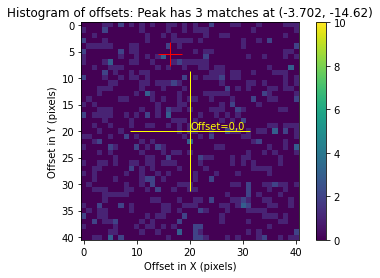

In [20]:
tweakreg.TweakReg('j8up02*raw.fits', updatehdr=True, reusename=True, interactive=False,
                  conv_width=3.0, threshold=300.0, peakmin=100, peakmax=10000)

### Edit this, currently copied.
This step adjusts image data values so that all images and chips appear (to AstroDrizzle) to have a single inverse sensitivity (PHOTFLAM). This can be achieved using the photeq task in Drizzlepac. This task adjusts image data so that when these data are multiplied by the same single PHOTFLAM value, the correct flux is obtained.

In [64]:
photeq.photeq?

In [65]:
tofix = []
for file in files:
    try:
        h = fits.getheader(file)
    except OSError:
        continue
    if 'PHOTFLAM' in h:
        tofix.append(file)
        
for file in tofix:
    photeq.photeq(files=file, ref_phot_ext=None, readonly=False)


***** drizzlepac.photeq started on 2022-08-29 14:46:47.380257
      Version 0.2 (06-Nov-2015)

PRIMARY PHOTOMETRIC KEYWORD: PHOTFLAM
SECONDARY PHOTOMETRIC KEYWORD(S): PHOTFNU
REFERENCE VALUE FROM FILE: 'j8up02usq_sci1_blt.fits[0]'
REFERENCE 'PHOTFLAM' VALUE IS: 1.3162776e-18

Processing file 'j8up02usq_sci1_blt.fits'
   * Primary header:
     - 'PHOTFLAM' = 1.3162776e-18 found in the primary header.
     - Data conversion factor based on primary header: 1.0

Done.
***** drizzlepac.photeq started on 2022-08-29 14:46:47.412837
      Version 0.2 (06-Nov-2015)

PRIMARY PHOTOMETRIC KEYWORD: PHOTFLAM
SECONDARY PHOTOMETRIC KEYWORD(S): PHOTFNU
REFERENCE VALUE FROM FILE: 'j8up02usq_single_sci.fits[0]'
REFERENCE 'PHOTFLAM' VALUE IS: 1.3162776e-18

Processing file 'j8up02usq_single_sci.fits'
   * Primary header:
     - 'PHOTFLAM' = 1.3162776e-18 found in the primary header.
     - Data conversion factor based on primary header: 1.0

Done.
***** drizzlepac.photeq started on 2022-08-29 14:46:47.435

REFERENCE 'PHOTFLAM' VALUE IS: 1.0143808e-18

Processing file 'j8up02v7q_single_sci.fits'
   * Primary header:
     - 'PHOTFLAM' = 1.0143808e-18 found in the primary header.
     - Data conversion factor based on primary header: 1.0

Done.
***** drizzlepac.photeq started on 2022-08-29 14:46:47.868430
      Version 0.2 (06-Nov-2015)

PRIMARY PHOTOMETRIC KEYWORD: PHOTFLAM
SECONDARY PHOTOMETRIC KEYWORD(S): PHOTFNU
REFERENCE VALUE FROM FILE: 'j8up02v9q_sci1_blt.fits[0]'
REFERENCE 'PHOTFLAM' VALUE IS: 6.2963406e-19

Processing file 'j8up02v9q_sci1_blt.fits'
   * Primary header:
     - 'PHOTFLAM' = 6.2963406e-19 found in the primary header.
     - Data conversion factor based on primary header: 1.0

Done.
***** drizzlepac.photeq started on 2022-08-29 14:46:47.901165
      Version 0.2 (06-Nov-2015)

PRIMARY PHOTOMETRIC KEYWORD: PHOTFLAM
SECONDARY PHOTOMETRIC KEYWORD(S): PHOTFNU
REFERENCE VALUE FROM FILE: 'j8up02v9q_single_sci.fits[0]'
REFERENCE 'PHOTFLAM' VALUE IS: 6.2963406e-19

Processing f

### Edit this, currently copied.
In the above command, we instruct photeq to "equalize" all chips of all input images using the first image as a reference. This reference PHOTFLAM value is printed out above, and stored in a reference file.

### Stacking images with tweakreg


In [66]:
astrodrizzle.AstroDrizzle('j8up02*flt.fits',
                          preserve=False,
                          driz_sep_bits='8,1024',
                          driz_sep_wcs=True,
                          driz_sep_scale=0.0996,
                          combine_type='median',
                          driz_cr_snr='5.5 3.5',
                          driz_cr_scale='2.0 1.5',
                          final_fillval=None,
                          final_bits='8,1024',
                          final_wcs=True,
                          final_scale=0.0996)

Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.1.8 (2020-07-27 10:34:52 -0400) started at: 14:47:50.359 (29/08/2022)

==== Processing Step  Initialization  started at  14:47:50.362 (29/08/2022)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 83.81914675198314  -5.39002696079146  
CRPIX : 533.3795180722892  520.8293172690763  
CD1_1 CD1_2  : -1.851293165171373e-05  2.0560053650305003e-05  
CD2_1 CD2_2  : 2.0560053650305003e-05  1.851293165171373e-05  
NAXIS : 1066  1041
********************************************************************************
*
*  Estimated memory usage:  up to 357 Mb.
*  Output image size:       1066 X 1041 pixels. 
*  Output image file:       ~ 12 Mb. 
*  Cores available:         8
*
********************************************************************************
==== Processing Step Initialization finished at 14:47:51.698 (29/08/2022)
==== Processing Step  Static Mask  started at  14:47:51.701 (29/08/2022)

==== Pro

Writing out image to disk: j8up02utq_single_wht.fits
Writing out image to disk: j8up02v5q_single_sci.fits
Writing out image to disk: j8up02v0q_single_wht.fits
Writing out image to disk: j8up02uyq_single_sci.fits
Writing out image to disk: j8up02uwq_single_sci.fits
Writing out image to disk: j8up02uuq_single_wht.fits
Writing out image to disk: j8up02usq_single_wht.fits
Writing out image to disk: j8up02uvq_single_wht.fits
Writing out image to disk: j8up02v5q_single_wht.fits
Writing out image to disk: j8up02uyq_single_wht.fits
Writing out image to disk: j8up02uwq_single_wht.fits
-Generating simple FITS output: j8up02v7q_single_sci.fits
-Generating simple FITS output: j8up02v9q_single_sci.fits
Writing out image to disk: j8up02v9q_single_sci.fits
Writing out image to disk: j8up02v7q_single_sci.fits
Writing out image to disk: j8up02v9q_single_wht.fits
Writing out image to disk: j8up02v7q_single_wht.fits
==== Processing Step Separate Drizzle finished at 14:47:58.085 (29/08/2022)
==== Processi

Finally, we visualize our beautiful combined image!

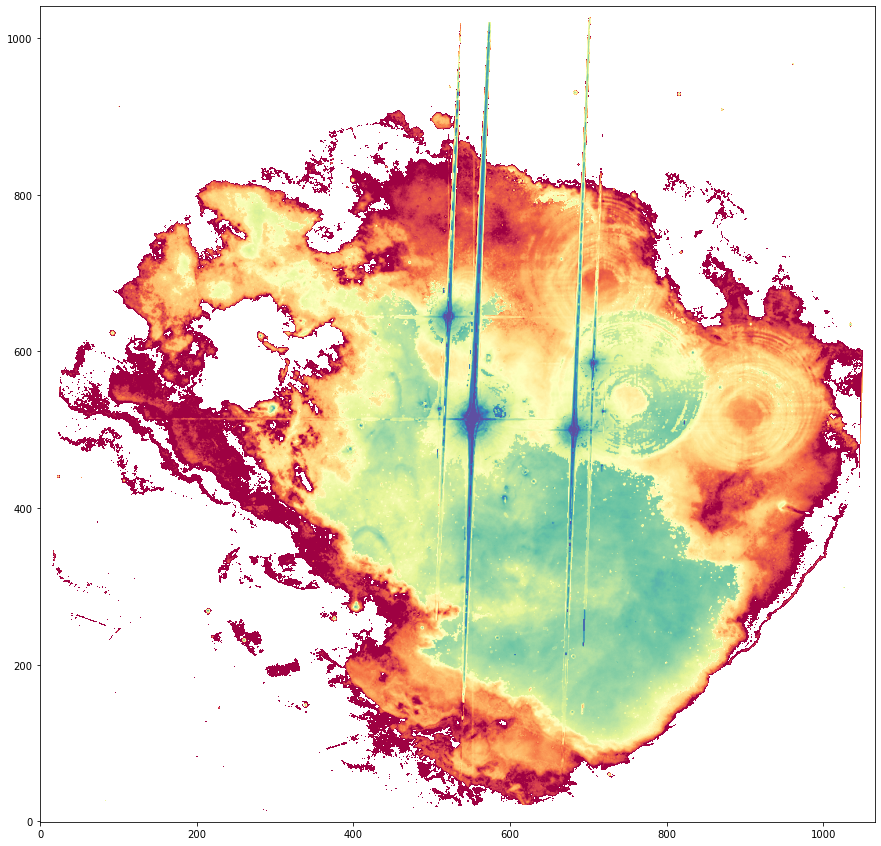

In [68]:
from matplotlib import colors
drz = fits.getdata('final_drz_sci.fits')
plt.figure(figsize=(15, 15))
drz.min(), np.nanmax(drz), drz[drz>0].min()
plt.imshow(drz, cmap='Spectral',norm = colors.LogNorm(1,1e3), origin='lower')

## Assignment 2

The above color scheme is a personal preference. Play around with the color map and scale to highlight the features that appeal to you the most. 

## Assignment 3

Notice that we only stacked the optical images so far! Repeat the above process for the infrared images, stored in the `infrared` table. Tip: compile the steps above into a function that takes the table and an output directory as its inputs. 

How do the images compare? What objects/processes can we learn from in the infrared that are hidden in the optical? What about the other way around?

***

## About this Notebook

**Author:** Urmila Chadayammuri, Postdoctoral Fellow, Smithsonian Astrophysical Observatory

**Updated On:** 2022-08-24

## Citations
Provide your reader with guidelines on how to cite open source software and other resources in their own published work.

```
If you use `astropy` for published research, please cite the
authors. Follow these links for more information about citing `astropy` and
`lightkurve`:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)

```

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 